<a href="https://colab.research.google.com/github/FHnt97/TOM_Thesis/blob/main/WESAD_Fairness_evaluation_of_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory analysis for fairness in a convoluted NN for the detection of stress

---


## Content:

Find an introduction to the aim and dataset in the README file.


- **Dataset**
    - WESAD dataset
    - **Sensitve attributes**: age (non binary attribute) & gender (binary attribute)
    - Unbalanced representation of groups in sample (sample size disparity)
- **Domain**
    - Operations management (stress detection) 
- **ML task**
    - Neutral network  
    
    > Adapted from [githum repo](https://github.com/arsen-movsesyan/springboard_WESAD) & Schmidt et al (2018) work. 
    > Code for data extraction [github repo](https://github.com/WJMatthew/WESAD) & [blog entry](https://godatadriven.com/blog/) 


- **Fairness tasks**
    - Assessment of fairness

    - *Not in notebook, but to consider for future projects:* 
       - *Mitigation of unfairness with the objective to of equal number of FALSE NEGATIVES for all (LAFTR, CFAIR, FFVAE)* 

- **Performance metrics**:
    - Confusion matrix
    - Accuracy & precision
    - ROC curves


- **Fairness metrics**:
    - Fairness metrics from the [FairDeepLearning](https://github.com/charan223/FairDeepLearning/tree/main/metrics) library
    - FN rate & Equal opportunity [link](https://fairware.cs.umass.edu/papers/Verma.pdf)
    - Accuracy

> NOTE: a FN means that someone who's stressed was not identifies and therefore recieved no support -- if stress/ fatigue is NOT detected when present, it can lead to dangerous situations for employees/ burnouts in the long term 





```
# Nomeclature: 

X ∈ Rᵈ: quantified features of the applicant

A ∈ {0, 1}: binary sensitive attribute gnder

C :=c(X,A) ∈ {0,1}: binary predictor (stressed vs. ok), which makes decision based on a score R:=r(x, a) ∈ [0,1]

Y ∈ {0, 1}: target variable

```








## BASE CODE

### Libraries

In [ ]:
# importing general libraries for the notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# libraries for data processing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
# imprt additional modules for later use
! pip install fairlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 177 kB 4.2 MB/s 


### Data load and wrangling

The exmploratory analysis of this dataset can be found in the first notebook on the dataset: WESAD - Debiasing Classification Algorithms

In [ ]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# open csv historical data
df = pd.read_csv('/content/drive/MyDrive/00 - thesis/Code/Datasets/WESAD/m14_merged.csv', sep=',', index_col=0)

In [ ]:
# reorder df columns & remove features which will not be used (lifestyle features, 3D data)
# remove min, max values, as mean & st. dev are already calculated
# remove according to corr analysis --> total of 18 attributes left 

cols = ['subject', 'label', 
        'age','gender_ female',
        'height', 'weight', 
        'BVP_std', 
        'EDA_mean', 'EDA_std', 
        'EDA_phasic_mean','EDA_phasic_std', 
        'EDA_smna_mean','EDA_smna_std', 
        'EDA_tonic_mean','EDA_tonic_std',  
        'Resp_std', 
        'TEMP_mean', 'TEMP_slope']

df = df[cols]


In [ ]:
# rename gender (male:0, female:1)
df = df.rename(columns = {'gender_ female':'gender'})

In [ ]:
# remove amusement state 
# 1: baseline, 2: stressed
df = df.loc[~(df['label'] == 0)]

In [ ]:
# chang 1,2 classification to 0,1 classification to avoid problems down the line
# 0: baseline, 1: stressed
df['label'] = df['label'].replace({1: 0})
df['label'] = df['label'].replace({2: 1})

gender
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

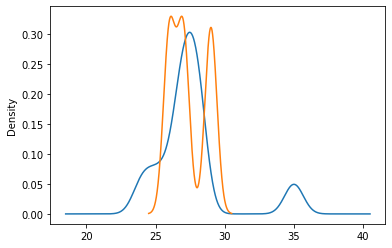

In [ ]:
# check gender & age representation 
df.groupby('gender').age.plot(kind='kde')

In [ ]:
# bin age into groups to noramlize (5 years)
def custom_round(x, base):
    return base * round(float(x)/5)

df['age'] = df.age.apply(lambda x: custom_round(x, 5))

In [ ]:
# check for correctness 
df.head()

,subject,label,age,gender,height,weight,BVP_std,EDA_mean,EDA_std,EDA_phasic_mean,EDA_phasic_std,EDA_smna_mean,EDA_smna_std,EDA_tonic_mean,EDA_tonic_std,Resp_std,TEMP_mean,TEMP_slope
0,2,0,25,0,175,80,107.648359,1.397968,0.141481,1.824289,1.088328,1.284376,1.952823,1.232164,0.997487,2.935617,35.817091,-0.000169
1,2,0,25,0,175,80,118.742089,1.210132,0.091882,2.109146,1.223528,1.467865,2.852510,0.377615,1.172221,2.843123,35.797568,-0.000789
2,2,0,25,0,175,80,42.190039,1.010977,0.102315,0.152828,0.128896,0.105091,0.244891,1.727696,0.293389,1.700333,35.712909,-0.000717
3,2,0,25,0,175,80,41.606872,0.775187,0.046391,0.177595,0.126167,0.110786,0.199704,0.987927,0.042388,1.483260,35.700811,0.000075
4,2,0,25,0,175,80,43.121633,0.657494,0.034540,0.035014,0.039616,0.026716,0.114738,0.772262,0.077628,1.501585,35.744727,0.000442


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983 entries, 0 to 1164
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   subject          983 non-null    int64  
 1   label            983 non-null    int64  
 2   age              983 non-null    int64  
 3   gender           983 non-null    int64  
 4   height           983 non-null    int64  
 5   weight           983 non-null    int64  
 6   BVP_std          983 non-null    float64
 7   EDA_mean         983 non-null    float64
 8   EDA_std          983 non-null    float64
 9   EDA_phasic_mean  983 non-null    float64
 10  EDA_phasic_std   983 non-null    float64
 11  EDA_smna_mean    983 non-null    float64
 12  EDA_smna_std     983 non-null    float64
 13  EDA_tonic_mean   983 non-null    float64
 14  EDA_tonic_std    983 non-null    float64
 15  Resp_std         983 non-null    float64
 16  TEMP_mean        983 non-null    float64
 17  TEMP_slope     

### Exploratory Analysis

---


We see that there is a clear underrepresentation of women, and peple over 30.

Furthermore, there is a strong correlation between gender & weight/ height. We therefore consider these attributes as a proxy to the sensitve attribute. These attributes will be removed from the equation to allow for unaware training.  

We also see:
- BVP & Resp EDA st.dev. correlatin with age 
- Temp correlation with age & gender


In [ ]:
# check for sample distributions
# count subjects by gender, age, label
df.groupby(["gender"])['gender'].count()/66 # on avg. each subject has 66 entries

gender
0    11.863636
1     3.030303
Name: gender, dtype: float64

In [ ]:
df.groupby(["age"])['age'].count()/66

age
25    8.848485
30    5.045455
35    1.000000
Name: age, dtype: float64

In [ ]:
df['label'].value_counts()

0    628
1    355
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


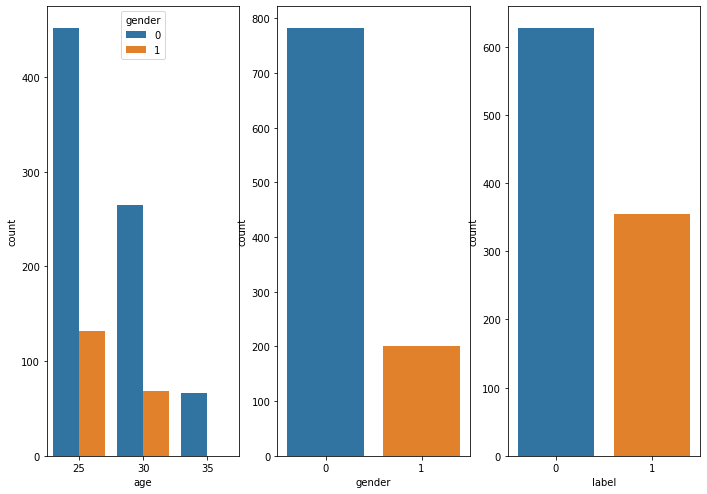

In [ ]:
# plot sample distributions
fig, ax = plt.subplots(1,3)
fig.set_size_inches(11.7, 8.27)
sns.countplot(df['age'], ax=ax[0], hue=df.gender)
sns.countplot(df['gender'], ax=ax[1])
sns.countplot(df['label'], ax=ax[2])  ## label 
fig.show()

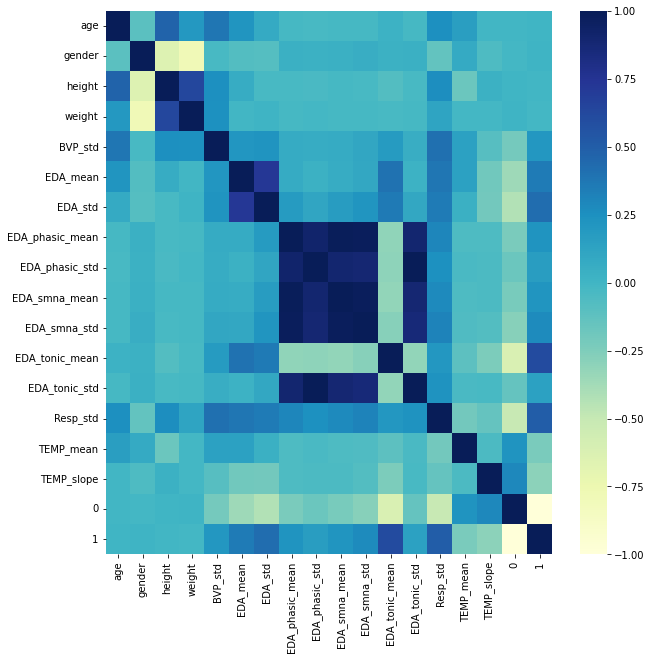

In [ ]:
# correlation analysis 
df_corr = pd.concat([df.drop('label', axis=1), pd.get_dummies(df['label'])], axis=1)
df_corr = df_corr.drop('subject', axis =1 )
corr = df_corr.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap="YlGnBu");

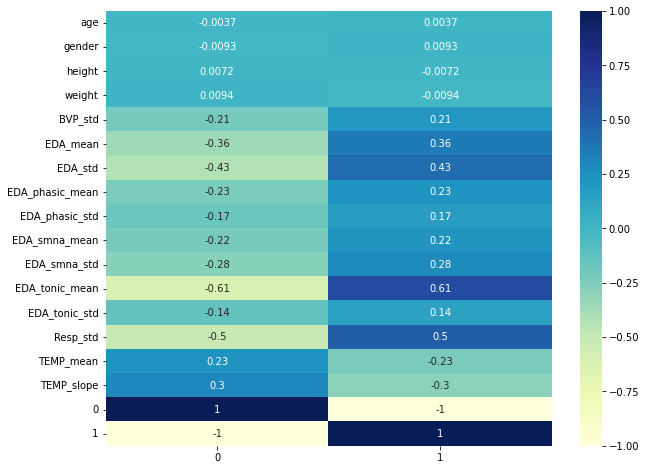

In [ ]:
feats = df.columns[1:]

df_corr = pd.concat([df[feats].drop('label', axis=1), pd.get_dummies(df[feats]['label'])], axis=1)
corr = df_corr.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr[[0, 1]], annot=True, cmap="YlGnBu")

<Figure size 720x720 with 0 Axes>

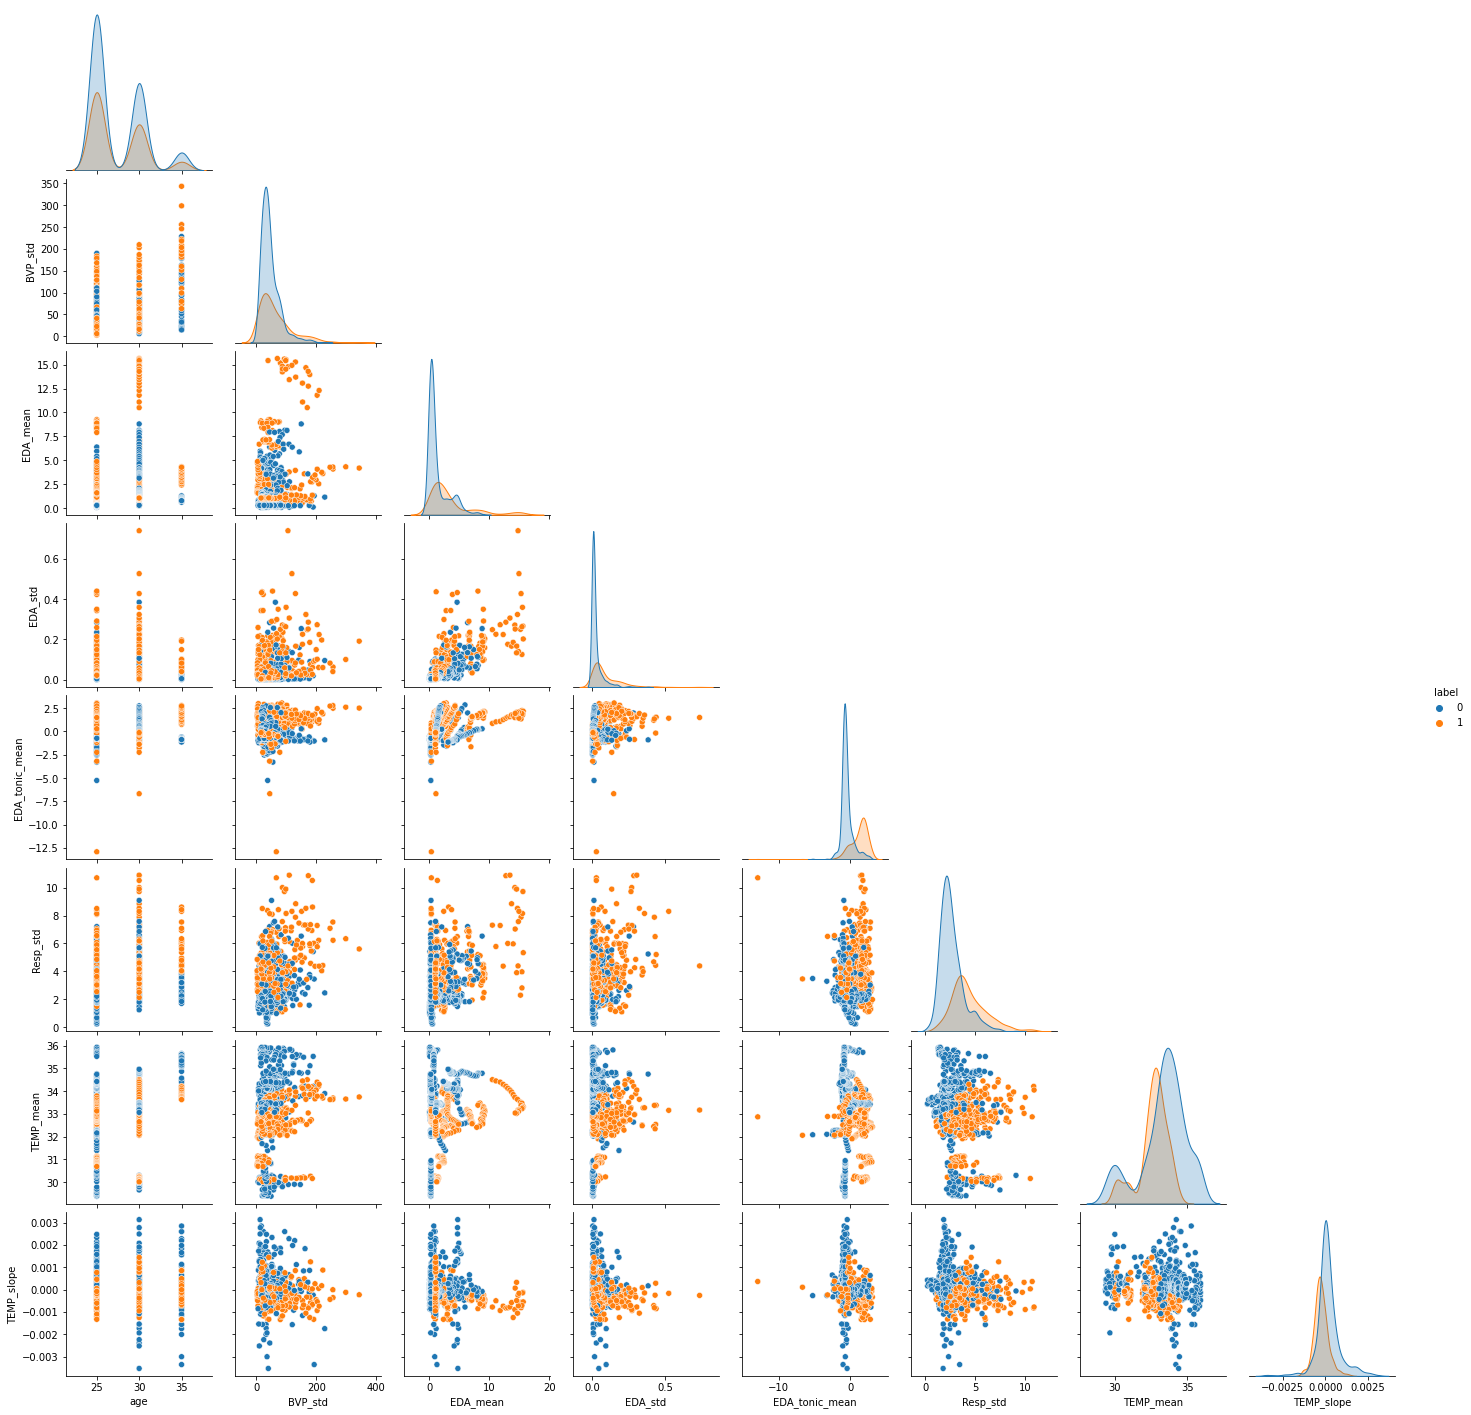

<Figure size 720x720 with 0 Axes>

In [ ]:
# to avoid logn processing times, load only most relevant data for pairplot
# check for any anomalies/ trends in correlaitons between attributes
cols2 = ['age','label', 
        'BVP_std', 
        'EDA_mean', 'EDA_std',  
        'EDA_tonic_mean',  
        'Resp_std', 
        'TEMP_mean', 'TEMP_slope']


sns.pairplot(df[cols2], hue="label", corner=True)
plt.figure(figsize=(10,10))

## Stress Model
-----


 In addition to the model presented in the WESAD - Debiaisng Classification Algorithm, [Stweard et al. (2020)](https://arxiv.org/pdf/2002.04176.pdf) present a **convoluted neural network** to detect stress for each participant usign torch.nn with:
  - 3 layers
  - 30 nodes latent variable 16 nodes
  - decoder with 3 dense 30 node hidden layers, dropout rate 0,2. 

The code below shows an adaptation of this model specific for the WESAD dataset with the objective to analyse how fair the model is for the different age and gender groups. 

#### libraries and helper functions

In [ ]:
# libraries for metrics of models
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    plot_confusion_matrix,
    classification_report,
    balanced_accuracy_score)

# torch for nn
import logging

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.utils.data import Dataset

import warnings
warnings.filterwarnings('ignore')


# libraries for fairness
from fairlearn.metrics import MetricFrame

# libraries for fairness
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    false_positive_rate, false_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference, true_positive_rate, true_negative_rate,
    equalized_odds_difference)

### NN (using py-torch)

In [ ]:
# check for cuda availability 
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# cuda not available - continue with CPU

Using cpu device


In [ ]:
# set up model: nn 
# take one berson as a ''batch'' - similarily as using one image for image recognition
# adapted from - https://www.cs.toronto.edu/~lczhang/360/lec/w02/training.html

class WESAD(Dataset):

    def __init__(self, dataframe):
        self.dataframe = dataframe.drop('subject', axis=1)
        self.labels = self.dataframe['label'].values
        self.dataframe.drop('label', axis=1, inplace=True)
    
    def __getitem__(self, id):
        x = self.dataframe.iloc[id].values
        y = self.labels[id]
        z = self.dataframe[['gender']].iloc[id].values
        return torch.Tensor(x), y, z

    def __len__(self):
        return len(self.dataframe)

logger = logging.getLogger(__name__)

In [ ]:
# get EACH subject individually
def get_data_loaders(dataframe, subject_id, train_batch_size=25, test_batch_size=5):
    
    # define one subject
    train_df = dataframe[ dataframe['subject'] != subject_id].reset_index(drop=True)
    test_df = dataframe[ dataframe['subject'] == subject_id].reset_index(drop=True)
    
    # create dataset for each subject
    train_dataset = WESAD(train_df)
    test_dataset = WESAD(test_df)

    # load for each subject (automatic batching + iterable dataset)
    # adapted form: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size)
    
    return train_loader, test_loader

In [ ]:
# data is temporal + of individual subject .: sequential
class nnetwork (nn.Module):
    def __init__(self):
        super(nnetwork, self).__init__()
        self.fc = nn.Sequential( # fully connected layer == fc
                        nn.Linear(16, 128), # cols -2 (cols subject & label)
                        nn.ReLU(),
                        nn.Dropout(p=0.2), # improve nn by preventing co-adaptation (regularization by disabling neurons)
                        nn.Linear(128, 256), # dimensions
                        nn.ReLU(),
                        nn.Linear(256, 2), # 1,2 as class labels .: make it a 3 class (0,1,2) classification problem 
                        nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        return self.fc(x)  

In [ ]:
def train(model, optimizer, train_loader, validation_loader):
    history = {'train_loss': {}, 'train_acc': {}, 'valid_loss': {}, 'valid_acc': {}}
    
    # for each epoch save data & save avg. in list --> # loop over dataset
    # https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    for epoch in range(num_epochs):

        # Train:   
        total = 0
        correct = 0
        trainlosses = []

        # train each subject (idx)
        for idx, (input, labels, sensitive) in enumerate(train_loader):

            # forward pass
            outputs = model(input.float())

            # loss
            loss = criterion(outputs, labels)

            # optimize
            optimizer.zero_grad()
            
            # backward 
            loss.backward()
            optimizer.step()

            trainlosses.append(loss.item())

            # compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() 
            total += len(labels)

        history['train_loss'][epoch] = np.mean(trainlosses) 
        history['train_acc'][epoch] = correct/total 

        # print for each 10 epochs for ALL subejcts
        if epoch % 10 == 0:
            with torch.no_grad():

                losses = []
                total = 0
                correct = 0

                for input, labels, sensitive in validation_loader:

                    # Forward pass
                    outputs = model(input.float())
                    loss = criterion(outputs, labels)

                    # Compute accuracy
                    _, argmax = torch.max(outputs, 1)
                    correct += (labels == argmax).sum().item() #.mean()
                    total += len(labels)

                    losses.append(loss.item())

                # save data    
                history['valid_acc'][epoch] = np.round(correct/total, 3)
                history['valid_loss'][epoch] = np.mean(losses)

                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses):.4}, Acc: {correct/total:.2}')
                
    return history

In [ ]:
def test(model, validation_loader):
    print('Evaluating model...')
    # Test
    model.eval()

    # reset 'memory' to have data on all subjects
    total = 0
    correct = 0
    testlosses = []
    correct_labels = []
    predictions = []

    # https://pytorch.org/docs/stable/generated/torch.no_grad.html
    with torch.no_grad():

        for batch_index, (input, labels, sensitive) in enumerate(validation_loader):

            # Forward pass
            outputs = model(input.float())

            # Loss
            loss = criterion(outputs, labels)

            testlosses.append(loss.item())

            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() #.mean()
            total += len(labels)

            correct_labels.extend(labels)
            predictions.extend(argmax)


    test_loss = np.mean(testlosses)
    accuracy = np.round(correct/total, 2)
    print(f'Loss: {test_loss:.4}, Acc: {accuracy:.2}')
    
    y_true = [label.item() for label in correct_labels]
    y_pred = [label.item() for label in predictions]

    cm = confusion_matrix(y_true, y_pred)

    return cm, test_loss, accuracy

In [ ]:
# learning Rate (as proposed by paper)
learning_rate = 5e-3

# epochs - avoid overfitting
num_epochs = 11

# loss and optimizer
# explanation provided at https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = nn.CrossEntropyLoss()

# emtry bins 
histories = []
confusion_matrices = []
test_losses = []
test_accs = []

subject_id_list = df['subject'].unique() 

# run all def. and class. for each subject and collect data separately 

for s in subject_id_list:
    print('\nSubject: ', s)

    # activate model
    model = nnetwork().to(device)

    # add optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # train/ test data loader for each subject
    train_loader, test_loader = get_data_loaders(df, s)
    
    # save results 
    history = train(model, optimizer, train_loader, test_loader)
    histories.append(history)
    
    cm, test_loss, test_acc = test(model, test_loader)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    confusion_matrices.append(cm)

### Model evaluation:


In [ ]:
# mean test accuracy accross all subjects 
np.mean(test_accs)

0.8613333333333333

In [ ]:
# plot results for each subject

plt.figure(figsize=(14, 6))
plt.title('Testing Accuracies by Subject in Testing Data')
sns.barplot(x=subject_id_list, y=test_accs, palette='YlGnBu');

### Fairness Measure (in model eval.)

---



We aim for group fairness, i.e., participants with similar characteristics should be treated similarily.
With this we consider disaggregated evaluations; evaluating perfromance with respect to different subgroups (age/ gender).


As states in the README, we aim for equal rate in False Negatives - equal opportunity. 

In [ ]:
# Note that only subjects 8, 11, and 17 are women
# 5 is the only subejct who is > 30 
gender_lst = df.groupby(['subject']).mean().gender.tolist()
age_lst = df.groupby(["subject"]).mean().age.tolist()
df_results = pd.DataFrame({'subject':subject_id_list,'accuracy':test_accs, 'gender': gender_lst, 'age': age_lst})

In [ ]:
# check fore accuracy in age & gender groups
df_results.groupby('gender').mean().accuracy

gender
0.0    0.924167
1.0    0.610000
Name: accuracy, dtype: float64

In [ ]:
df_results.groupby('age').mean().accuracy

age
25.0    0.907778
30.0    0.756000
35.0    0.970000
Name: accuracy, dtype: float64

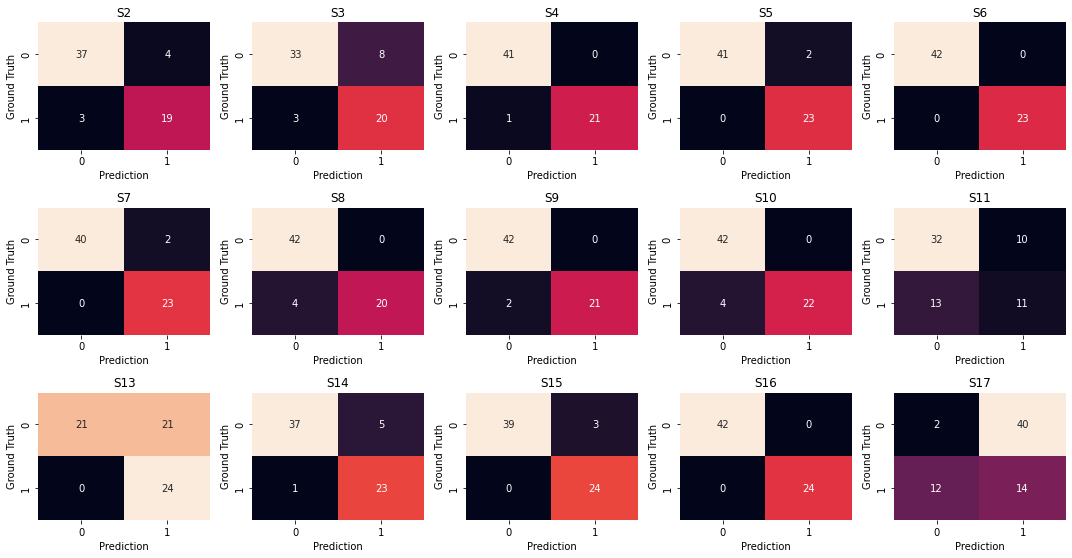

In [ ]:
# plot confusion matrix to see FN rates and differences between subjects
plt.figure(figsize=(15,10))

for i in range(15):
    plt.subplot(4,5 ,i+1)
    cm = confusion_matrices[i]
    
    
    sns.heatmap(cm, annot=True, fmt='d', cbar=False);
    plt.title(f'S{subject_id_list[i]}')
    plt.xlabel('Prediction');
    plt.ylabel('Acutal value');
plt.tight_layout();

From the diagrams above, we see a discrepency between the accuracy in the genders.

With the objective to balance for the negative class ( a continuation of Equalized Odds), future work should also be done in this instance to mitigate bias. 


Balance for the negative class requires  the average score of those who belong to the negative class be the same across groups:
`E[S|Y=1,A=a]=E[S|Y=1,A=b]`

See more definitions [here](https://afraenkel.github.io/fairness-book/content/07-score-functions.html).

#### helper functions


In [ ]:
class Metric:
    def __init__(self):
        self.name = (
            "Name not implemented"  ## This should be replaced in implemented metrics.
        )
        self.iter_counter = 0

    def __iter__(self):
        self.iter_counter = 0
        return self

    def __next__(self):
        self.iter_counter += 1
        if self.iter_counter > 1:
            raise StopIteration
        return self

    def calc(
        self,
        actual,
        predicted,
        dict_of_sensitive_lists,
        single_sensitive_name,
        unprotected_vals,
        positive_pred,
    ):
        """
        actual                          a list of the actual results on the test set
        predicted                       a list of the predicted results
        dict_of_sensitive_lsits         dict mapping sensitive attr names to list of sensitive vals
        single_sensitive_name           sensitive name (dict key) for the sensitive attr being
                                        focused on by this run of the algorithm
        unprotected_vals                a list of the unprotected values for all sensitive attrs
        positive_pred                   the positive value of the prediction task.
        returns                         the calculated result for this metric
        The actual and predicted results and the sensitive attribute lists in the dict should have
        the same length (the length of the test set).
        If there is an error and the metric can not be calculated (e.g., no data is passed in), the
        metric returns None.
        """
        raise NotImplementedError("calc() in Metric is not implemented")

    def get_name(self):
        """
        Returns a name for the metric.  This will be used as the key for a dictionary and will
        also be printed to the final output file.
        """
        return self.name

    def is_better_than(self, val1, val2):
        """
        Compares the two given values that were calculated by this metric and returns true if
        val1 is better than val2, false otherwise.
        """
        return val1 > val2

    def expand_per_dataset(self, privileged_vals, sensitive_dict):
        """
        !Changed to work with MNIST variants!
        Optionally allows the expansion of the metric into a returned list of metrics based on the
        dataset, e.g., where there is one metric per sensitive attribute given, and a dictionary
        mapping sensitive attributes to all seen sensitive values from the data.
        """
        return self

In [ ]:
def calc_pos_protected_percents(predicted, sensitive, unprotected_vals, positive_pred):
    """
    Returns P(C=YES|sensitive=privileged) and P(C=YES|sensitive=not privileged) in that order where
    C is the predicited classification and where all not privileged values are considered
    equivalent.  Assumes that predicted and sensitive have the same lengths.
    """
    unprotected_positive = 0.0
    unprotected_negative = 0.0
    protected_positive = 0.0
    protected_negative = 0.0
    for i in range(0, len(predicted)):
        protected_val = sensitive[i]
        predicted_val = predicted[i]
        if protected_val in unprotected_vals:
            if str(predicted_val) == str(positive_pred):
                unprotected_positive += 1
            else:
                unprotected_negative += 1
        else:
            if str(predicted_val) == str(positive_pred):
                protected_positive += 1
            else:
                protected_negative += 1

    protected_pos_percent = 0.0
    if protected_positive + protected_negative > 0:
        protected_pos_percent = protected_positive / (
            protected_positive + protected_negative
        )
    unprotected_pos_percent = 0.0
    if unprotected_positive + unprotected_negative > 0:
        unprotected_pos_percent = unprotected_positive / (
            unprotected_positive + unprotected_negative
        )

    return unprotected_pos_percent, protected_pos_percent


def calc_prob_class_given_sensitive(
    predicted, sensitive, predicted_goal, sensitive_goal
):
    """
    Returns P(predicted = predicted_goal | sensitive = sensitive_goal).  Assumes that predicted
    and sensitive have the same length.  If there are no attributes matching the given
    sensitive_goal, this will error.
    """
    match_count = 0.0
    total = 0.0
    for sens, pred in zip(sensitive, predicted):
        if str(sens) == str(sensitive_goal):
            total += 1
            if str(pred) == str(predicted_goal):
                match_count += 1

    return match_count / total


def calc_fp_fn(actual, predicted, sensitive, unprotected_vals, positive_pred):
    """
    Returns False positive and false negative for protected and unprotected group.
    """
    unprotected_negative = 0.0
    protected_positive = 0.0
    protected_negative = 0.0
    fp_protected = 0.0
    fp_unprotected = 0.0
    fn_protected = 0.0
    fn_unprotected = 0.0
    fp_diff = 0.0
    for i in range(0, len(predicted)):
        protected_val = sensitive[i]
        predicted_val = predicted[i]
        actual_val = actual[i]
        if protected_val in unprotected_vals:
            if (str(predicted_val) == str(positive_pred)) & (
                str(actual_val) != str(predicted_val)
            ):
                fp_unprotected += 1
            elif (str(predicted_val) != str(positive_pred)) & (
                str(actual_val) == str(predicted_val)
            ):
                fn_unprotected += 1
        else:
            if (str(predicted_val) == str(positive_pred)) & (
                str(actual_val) != str(predicted_val)
            ):
                fp_protected += 1
            elif (str(predicted_val) != str(positive_pred)) & (
                str(actual_val) == str(predicted_val)
            ):
                fn_protected += 1
    return fp_unprotected, fp_protected, fn_protected, fn_unprotected
    

In [ ]:
""" Equal opportunity - Protected and unprotected False negative difference"""

class EqOppo_fn_diff(Metric):
    def __init__(self):
        Metric.__init__(self)
        self.name = "EqOppo_fn_diff"

    def calc(
        self,
        actual,
        predicted,
        dict_of_sensitive_lists,
        single_sensitive_name,
        unprotected_vals,
        positive_pred,
    ):
        sensitive = dict_of_sensitive_lists[single_sensitive_name]
        fp_unprotected, fp_protected, fn_protected, fn_unprotected = calc_fp_fn(
            actual, predicted, sensitive, unprotected_vals, positive_pred
        )

        fn_diff = math.fabs(fn_protected - fn_unprotected)

        return fn_diff

In [ ]:
class Accuracy(Metric):
    """returns the fraction of correctly classified samples (float)"""

    def __init__(self):
        Metric.__init__(self)
        self.name = "accuracy"

    def calc(
        self,
        actual,
        predicted,
        dict_of_sensitive_lists,
        single_sensitive_name,
        unprotected_vals,
        positive_pred,
    ):

        return accuracy_score(actual, predicted)

In [ ]:
class CV(Metric):
    def __init__(self):
        Metric.__init__(self)
        self.name = "CV"

    def calc(
        self,
        actual,
        predicted,
        dict_of_sensitive_lists,
        single_sensitive_name,
        unprotected_vals,
        positive_pred,
    ):
        sensitive = dict_of_sensitive_lists[single_sensitive_name]
        unprotected_pos_percent, protected_pos_percent = calc_pos_protected_percents(
            predicted, sensitive, unprotected_vals, positive_pred
        )
        CV = unprotected_pos_percent - protected_pos_percent
        return 1.0 - abs(CV)

    def is_better_than(self, val1, val2):
        dist1 = math.fabs(1.0 - val1)
        dist2 = math.fabs(1.0 - val2)
        return dist1 < dist2

#### dashboard


# AI fairness - Future considerations
---

Consider best practices:
  - dataset documentation
  - model reporting and curation
  - reproducibility and transparency



Mitigation of NN:

Considerations - are we minitating bias (removing the problematic signal) - OR adding inclusion (add singal for deasired features for a re-weighted singal improved fairness?


Bias can come from the acutal data or the algorithm (this includes technical bias from data processing & amplified bias from the feedback loops)



pre-processing: supression, class relabeling, reweighing, data transportation, database reparis, data augmentation



Learned latent structures & adversarial learning structures


We will run the no debias nn, fair, cfair-eo, and cfair models

https://afraenkel.github.io/fairness-book/content/07-score-functions.html


see link for codes


## Archive - ideas & textt

https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb 



Objectives: find out who is the data?
  - what is missing?
  - whats being overgeneralized?
  - whats being underrepresented?
  - how do the varibales and their values reflect the real world?
  - what might be leaving out?


Methodology:

1.   gender & age distributions (age distribution by gender)
2.   distributions of other diverse attributes
2.   correlation analysis
3.   class impalances (frequencies in reality vs. dataset)


We find bias in rows - (not enough representation); and bias in columns (features are correlated with sensitive attributes) - the case study focuses on bias on columns


---

Considerations when looking at the data:
1. how is it labeled and categorized
2. how do we simplify it/normalize it to create a good generic algorithm
3. are there any atipical cases that could not fit into the prototype/ stereotype of the normalized data 